In [1]:
import sys

sys.path.append("..")

import tensorflow as tf

import numpy as np

import GPyOpt

import argparse

from utils import tf_config, preprocess_data, search_algorithms, train

from models import fmri_ae, eeg_to_fmri, uniconv_fmri

from layers import locally_connected

import matplotlib.pyplot as plt

import gc

import os

from sklearn.model_selection import train_test_split, KFold

import time

dataset="01"
memory_limit=1500
n_individuals=8
interval_eeg=6

tf_config.set_seed(seed=42)
tf_config.setup_tensorflow(device="GPU", memory_limit=memory_limit)

with tf.device('/CPU:0'):
    train_data, _ = preprocess_data.dataset(dataset, n_individuals=n_individuals, 
                                            interval_eeg=interval_eeg, 
                                            ind_volume_fit=False,
                                            standardize_fmri=False,
                                            iqr=True,
                                            verbose=True)
    _, fmri_train =train_data
    #eeg_val, fmri_val =val_data
    
    fmri_train = fmri_train[:296]
    
    train_x, val_x = train_test_split(fmri_train, test_size=0.2, shuffle=True, random_state=42)

warning in stationary: failed to import cython module: falling back to numpy
warning in coregionalize: failed to import cython module: falling back to numpy
warning in choleskies: failed to import cython module: falling back to numpy
I: Starting to Load Data
I: Finished Loading Data
I: Pairs Created


## Create dataset and hyperparameter definition

In [2]:
batch_size=16
learning_rate=0.0001
skip_connections=True
maxpool=True
batch_norm=True
weight_decay=1e-5
n_channels=16
latent_dimension=(5,5,5)
kernel_size=(9,9,4)
stride_size=(1,1,1)
encoding_kernel_size=(3,3,3)
encoding_stride_size=(1,1,1)
n_stacks=3

optimizer = tf.keras.optimizers.Adam(learning_rate)
loss_fn = tf.keras.losses.MSE

train_set = tf.data.Dataset.from_tensor_slices((train_x, train_x)).batch(batch_size)
dev_set = tf.data.Dataset.from_tensor_slices((val_x, val_x)).batch(1)

## Build model

In [3]:
import importlib
importlib.reload(fmri_ae)

with tf.device('/CPU:0'):
    model = fmri_ae.fMRI_AE(latent_dimension, train_x.shape[1:], 
                    kernel_size, stride_size, n_channels,
                    maxpool=maxpool, batch_norm=batch_norm, weight_decay=weight_decay, 
                    skip_connections=skip_connections, n_stacks=n_stacks, 
                    local=True, local_attention=False, outfilter=0)
    
    model.build(input_shape=(None,)+train_x.shape[1:])

## Number of parameters

In [4]:
print(model.summary())

Model: "f_mri_ae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 5, 5, 5)           1950893   
_________________________________________________________________
model_1 (Functional)         (None, 64, 64, 30, 1)     15482880  
Total params: 17,433,773
Trainable params: 17,433,453
Non-trainable params: 320
_________________________________________________________________
None


In [5]:
model.encoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 30,  0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 56, 56, 27, 1 5200        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling3d (MaxPooling3D)    (None, 55, 55, 27, 1 0           conv3d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 55, 55, 27, 1 64          max_pooling3d[0][0]              
______________________________________________________________________________________________

## Train

In [6]:
start_time = time.time()

#train
train_loss, val_loss = train.train(train_set, model, optimizer, 
                                   loss_fn, epochs=10, 
                                   val_set=dev_set, verbose=True)

print("Time training: ", time.time()-start_time)

Epoch 1 with loss: 150155.74973958332
Epoch 2 with loss: 11331.629996744792
Epoch 3 with loss: 2092.7581868489583
Epoch 4 with loss: 862.6957356770833
Epoch 5 with loss: 518.0106953938802
Epoch 6 with loss: 750.5633850097656
Epoch 7 with loss: 992.8703165690105
Epoch 8 with loss: 1130.3309753417968
Epoch 9 with loss: 620.5688313802083
Epoch 10 with loss: 541.1321248372395
Time training:  1912.808266401291


## Plot learning history

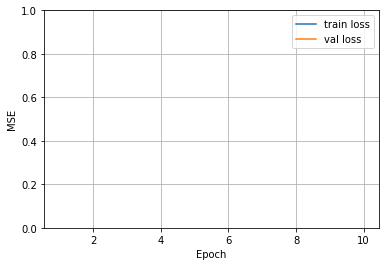

In [7]:
plt.figure()

plt.plot(range(1,10+1), train_loss, label="train loss")
plt.plot(range(1,10+1), val_loss, label="val loss")

plt.ylim(0,np.amax(np.amax(train_loss), np.amax(val_loss)))

plt.xlabel("Epoch")
plt.ylabel("MSE")

plt.grid(True)
plt.legend()

plt.show()

## Visualize brain slices

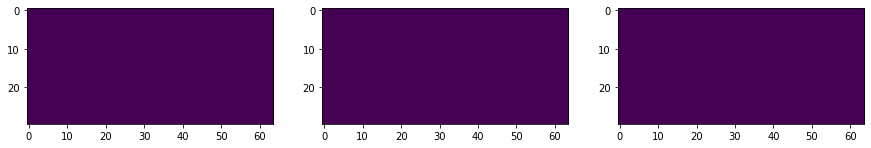

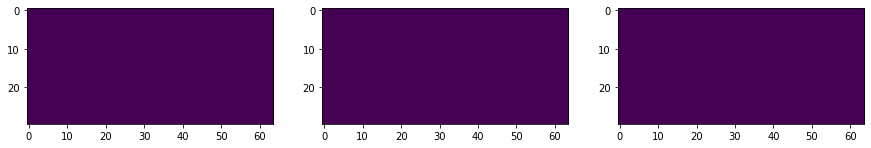

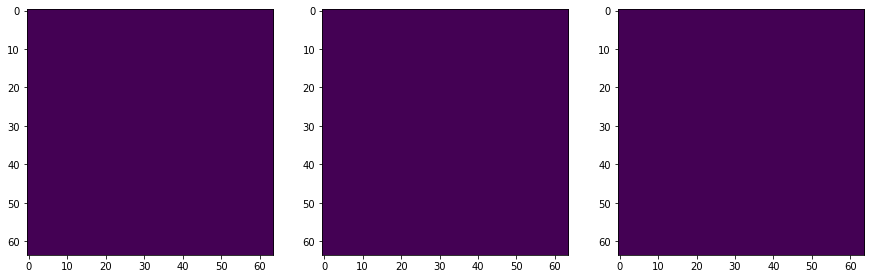

In [19]:
from scipy.ndimage import rotate

volume=291
xslice=30
yslice=30
zslice=15
array_set=fmri_train

fig, axes = plt.subplots(1, 3, figsize=(15,30))
axes[0].imshow(rotate(array_set[volume,xslice,:,:,:], 90))
axes[1].imshow(rotate(model(array_set[volume:volume+1]).numpy()[0,xslice,:,:,:], 90, axes=(0,1)))
difference = np.abs(rotate(array_set[volume,xslice,:,:,:], 90)-rotate(model(array_set[volume:volume+1]).numpy()[0,xslice,:,:,:], 90, axes=(0,1)))
axes[2].imshow(difference)
plt.show()


fig, axes = plt.subplots(1, 3, figsize=(15,30))
axes[0].imshow(rotate(array_set[volume,:,yslice,:,:], 90))
axes[1].imshow(rotate(model(array_set[volume:volume+1]).numpy()[0,:,yslice,:,:], 90, axes=(0,1)))
difference = np.abs(rotate(array_set[volume,:,yslice,:,:], 90)-rotate(model(array_set[volume:volume+1]).numpy()[0,:,yslice,:,:], 90, axes=(0,1)))
axes[2].imshow(difference)
plt.show()


fig, axes = plt.subplots(1, 3, figsize=(15,30))
axes[0].imshow(array_set[volume,:,:,zslice,:])
axes[1].imshow(model(array_set[volume:volume+1]).numpy()[0,:,:,zslice,:])
difference = np.abs(array_set[volume,:,:,zslice,:]-model(array_set[volume:volume+1]).numpy()[0,:,:,zslice,:])
axes[2].imshow(difference)
plt.show()

In [8]:
model

In [9]:
loss_fn

<function tensorflow.python.keras.losses.mean_squared_error(y_true, y_pred)>

In [7]:
residuals=[]

for i in range(fmri_train.shape[0]):
    residuals.append(tf.reduce_mean(loss_fn(fmri_train[i], model(fmri_train[i:i+1]))).numpy())

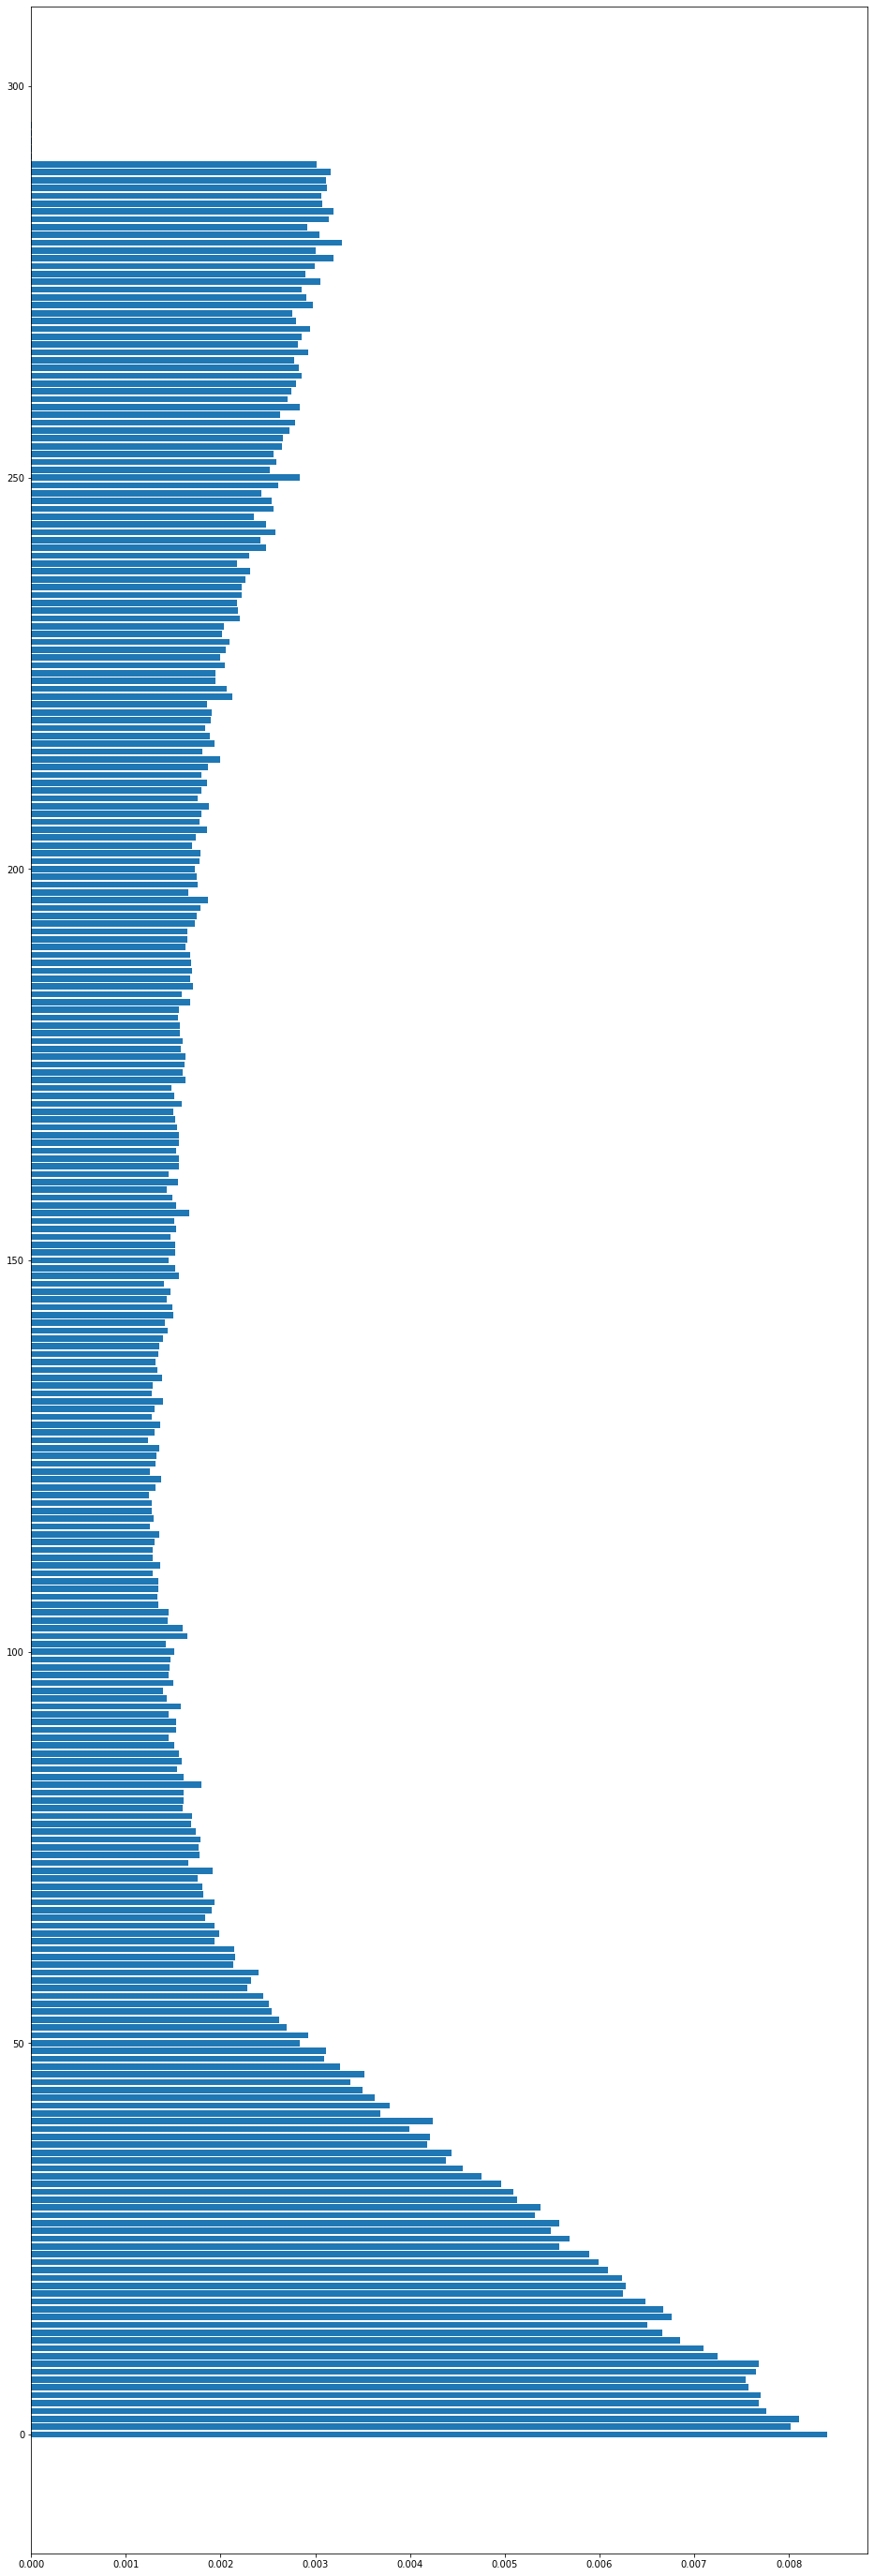

In [8]:
plt.figure(figsize=(16,50))
plt.barh(np.arange(0,fmri_train.shape[0],1), residuals, 0.8)
plt.show()

In [9]:
np.mean(residuals)

0.0025228437

In [10]:
for i in range(len(residuals)):
    print(residuals[i])

0.008409638
0.008022757
0.008107271
0.0077576865
0.007678461
0.0077054063
0.0075719296
0.0075475476
0.0076554
0.007678789
0.0072439876
0.007096549
0.0068550655
0.0066626095
0.0065030456
0.0067598587
0.006671509
0.006489831
0.0062535936
0.0062771826
0.0062392275
0.006094838
0.0059879813
0.0058961185
0.0055780383
0.0056835213
0.0054846364
0.0055750813
0.005317315
0.00538159
0.0051268805
0.0050958027
0.0049669826
0.004760218
0.004556448
0.0043794275
0.0044341143
0.0041845147
0.0042141
0.0039930185
0.004238712
0.003688474
0.0037844542
0.0036261703
0.0035009438
0.0033658992
0.0035164915
0.0032601678
0.0030890345
0.0031138842
0.0028366318
0.002921142
0.0027020841
0.0026180635
0.002535585
0.0025068345
0.0024552017
0.0022829918
0.0023208165
0.0023996287
0.0021324412
0.0021506706
0.0021401977
0.0019398339
0.0019822617
0.0019393705
0.0018366391
0.0019086881
0.0019335228
0.0018191957
0.0018128617
0.0017570582
0.0019121348
0.0016639752
0.0017786031
0.0017709135
0.0017845903
0.0017417945
0.00168689